In [1]:
import argparse
import cv2
import numpy as np
import networkx as nx
import os
from itertools import combinations
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import Compose
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from viz_3d import *

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d

import pypose as pp

from SLAM.UZH_FPV_Dataset import UZH_FPV_Dataset

os.chdir("./DepthAnything/")
from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

/home/ilari/miniconda3/envs/matine/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/ilari/miniconda3/envs/matine/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Initialize Dataset

/home/ilari/Documents/MATINEDepthSemanticSLAM/SLAM/UZH_FPV_Dataset.py:84: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  R=torch.tensor([np.eye(3)]),


tensor([[259.9811,   0.0000, 298.3111],
        [  0.0000, 258.0602, 224.2180],
        [  0.0000,   0.0000,   1.0000]]) tensor([-0.0137,  0.0207, -0.0128,  0.0025,  0.0000,  0.0000]) (686, 518)
torch.Size([10, 3, 518, 686]) torch.Size([1509, 1]) torch.Size([1509, 3]) torch.Size([1509, 3]) torch.Size([10, 7])


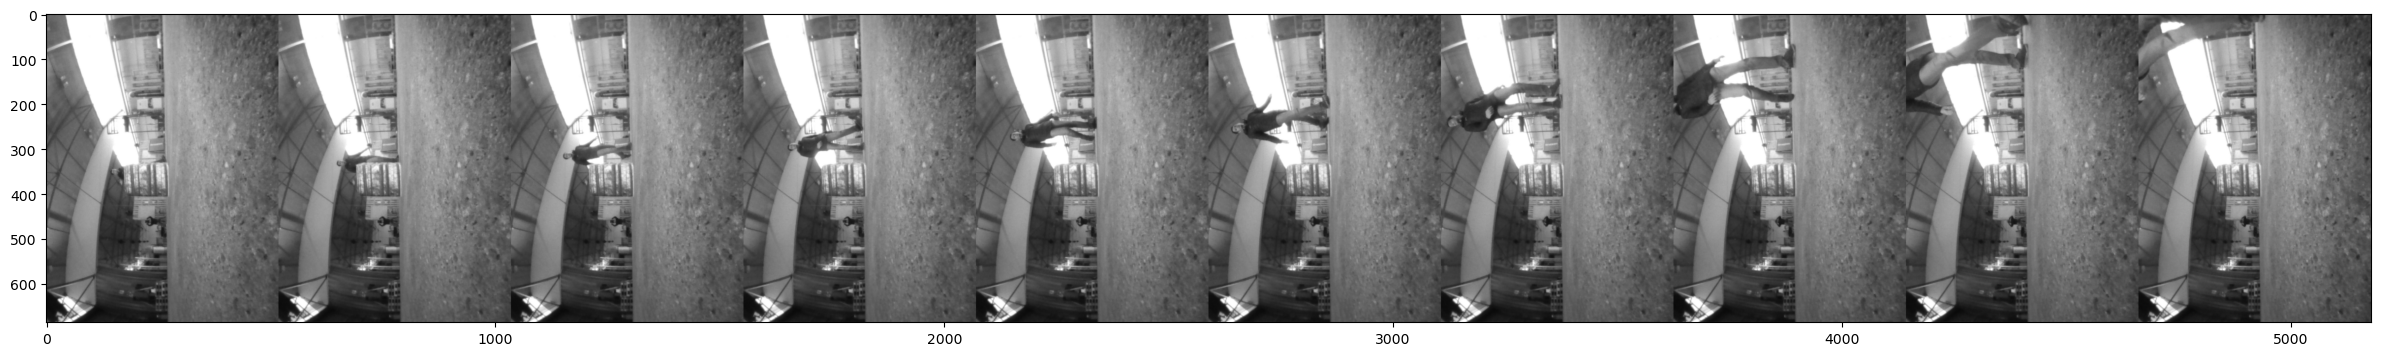

In [2]:
transform = Compose(
    [
        Resize(
            width=518,
            height=518,
            resize_target=False,
            keep_aspect_ratio=True,
            ensure_multiple_of=14,
            resize_method="lower_bound",
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        # NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # PrepareForNet(),  # this makes the image (and training masks) contiguous and floats
    ]
)

seq_len = 10

dataset = UZH_FPV_Dataset(
    path="/home/ilari/Downloads/indoor_forward_6_snapdragon_with_gt",
    transforms=transform,
    sequence_length=seq_len,
    skip_frames=10,
)

X = dataset[0]
print(X["cam0"].shape, X["dt"].shape, X["acc"].shape, X["gyro"].shape, X["gt_pose"].shape)

s, h, w, c = X["cam0"].shape

plt.figure(figsize=(30, 10))
plt.imshow(np.concatenate(tuple(X["cam0"].permute(0,3,2,1)), axis=1));

### Initialize Models

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Camera model
fish_cam = dataset.camera_model.to(device)

# Depth Anything
depth_anything = DepthAnything.from_pretrained("LiheYoung/depth_anything_vitb14").to(device).eval()
total_params = sum(param.numel() for param in depth_anything.parameters())
print("DepthAnything parameters: {:.2f}M".format(total_params / 1e6))

# Extractor and matcher
extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)


# IMU
integrator = pp.module.IMUPreintegrator(gyro_cov=0.00016, acc_cov=0.0028, reset=True).to(device)

cuda


xFormers not available
xFormers not available


DepthAnything parameters: 97.47M


In [4]:
def DepthAnythingProcess(batch):
    mean = torch.tensor([0.485, 0.456, 0.406], device=batch.device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=batch.device).view(1, 3, 1, 1)
    batch = (batch - mean) / std
    batch = batch.contiguous()
    return batch

def extract_keypoints(image, extractor, device):
    #image = load_image(img_path)
    feats = extractor.extract(image.to(device))
    return feats


def match_keypoints(feats0, feats1, matcher):
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]
    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]
    return m_kpts0, m_kpts1, matches01

def covisibility_graph(num_cams, matches):
    G = nx.Graph()
    for cam_idx in range(num_cams - 1):
        for i, j in matches[cam_idx]:
            G.add_edge((cam_idx, i), (cam_idx + 1, j))

    TC = nx.transitive_closure(G, reflexive=False)
    components = nx.connected_components(TC)
    points3D = [sublist for sublist in components if len(sublist) >= 3]

    cam2pointidx = defaultdict(list)
    for pt_idx, pt in enumerate(points3D):
        for cam, _ in pt:
            cam2pointidx[cam].append(pt_idx)

    return points3D, cam2pointidx

def project_keypoint_batch(camera_model, poses, batch_keypoints, batch_depths):
    points3D = []
    for pose, keypoints, depths in zip(poses, batch_keypoints, batch_depths):
        U, V = torch.split(keypoints["keypoints"].int(),1, dim=-1)
        keypoint_depths = depths[U, V]
        u_vectors = F.normalize(camera_model.unproject_points(keypoints["keypoints"]))
        points = pose @ (u_vectors * keypoint_depths)
        points3D.append(points)
    return points3D

def triangulate_matched_points(covis_graph, camera_model, poses, batch_keypoints, batch_depths):
    cam2point = defaultdict(list)
    points3D = []
    for i, point in enumerate(covis_graph):
        mean_point = []
        for cam, feature_idx in point:
            pose = poses[cam]
            keypoint = batch_keypoints[cam]['keypoints'][0, feature_idx]
            depth = batch_depths[cam, int(keypoint[1]), int(keypoint[0])] # Keypoints are always in reverse order (V,U)
            unit_vector = F.normalize(camera_model.unproject_points(keypoint[None]))
            point3d = pose @ (unit_vector * depth)
            mean_point.append(point3d)
            # Mapping: cam -> (keypoint_idx, 3Dpoints_idx)
            cam2point[cam].append((feature_idx, i))
        points3D.append(torch.vstack(mean_point).mean(dim=0))
    points3D = torch.vstack(points3D)
    return points3D, cam2point

# def project_keypoint_batch(camera_model, poses, batch_keypoints, batch_depths):
#     points3D = []
#     K = torch.tensor(dataset.K, device=device)
#     for pose, keypoints, depths in zip(poses, batch_keypoints, batch_depths):
#         keypoints = keypoints['keypoints'][0] # [N, 2]
#         N = keypoints.shape[0]
#         keypoint_depths = depths[keypoints[:,0].int(), keypoints[:,1].int()]
#         keypoints = torch.cat((keypoints, torch.ones(N, device=keypoints.device).view(-1,1)), dim=-1)
#         undistorted_pixels = F.normalize(camera_model.transform_points(keypoints))[:, :2]
#         points = pp.pixel2point(undistorted_pixels, keypoint_depths, torch.eye(3, device=device))
#         points3D.append(points)
#     return points3D

def batch2device(tensor_dict, device):
    return {k: v.to(device) for k, v in tensor_dict.items()}

In [5]:
K = torch.tensor(dataset.K).float().to(device)

/tmp/ipykernel_16618/566495070.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  K = torch.tensor(dataset.K).float().to(device)


In [6]:
# Training loop
for batch_idx, data in enumerate(dataset):
    data = batch2device(data, device)
    image_batch = data["cam0"]
    feature_points = []
    all_matches = []

    # Get initial poses through IMU
    init_state = {
        'pos': data['gt_pose'][0].translation(),
        'rot' : data['gt_pose'][0].rotation(),
        'vel' : data['velocity']
    }
    state = integrator(dt=data['dt'] , 
                    gyro=data['gyro'],
                    acc=data['acc'],
                    init_state=init_state)
    
    imu_freq = data['dt'].shape[0] // image_batch.shape[0]
    imu_poses = pp.SE3(torch.cat((state['pos'], state['rot']), dim=-1))
    imu_poses = imu_poses[0, ::imu_freq][:image_batch.shape[0]]

    # Extract keypoints
    for i in range(image_batch.shape[0]):
        feature_points.append(extract_keypoints(image_batch[i:i+1], extractor, device))

    # Match keypoints
    for i in range(len(feature_points)-1):
        m_kpts0, m_kpts1, matches01 = match_keypoints(feature_points[i], feature_points[i+1], matcher)
        all_matches.append(matches01["matches"].cpu().numpy())

    # Create covisibility graph
    covis_graph, cam2point = covisibility_graph(image_batch.shape[0], all_matches)
    
    image_batch = DepthAnythingProcess(image_batch)

    with torch.no_grad():
        depths = depth_anything(image_batch)
        depths = depths / 5 # Scale depth if needed
        
    # Naive, extremely slow point triangulation, ~2mins for 1000 points.
    points3D, cam2point = triangulate_matched_points(covis_graph, fish_cam, imu_poses, feature_points, depths)

    # if batch_idx > 50:
    break

/home/ilari/miniconda3/envs/matine/lib/python3.9/site-packages/pypose/lietensor/lietensor.py:918: UserWarning: Tensor Shape Invalid by calling <built-in method cat of type object at 0x7f869e67a840>, go to https://pypose.org/docs/main/generated/pypose.LieTensor
  warnings.warn('Tensor Shape Invalid by calling {}, ' \


### Visualize Poses and Points for Initialized Conditions

In [7]:
def visualize_batch(poses, gt_poses, points):
    fig = init_figure()
    fig.update_layout(showlegend=True)
    for pose, gt_pose in zip(poses, gt_poses):
        R = pose.rotation().matrix().cpu().numpy()
        t = pose.translation().cpu().numpy()
        Rgt = gt_pose.rotation().matrix().cpu().numpy()
        tgt = gt_pose.translation().cpu().numpy()
        intrinsics = dataset.K.numpy()        
        plot_camera(fig, Rgt, tgt, intrinsics, text="gt", size=1, color="blue")
        plot_camera(fig, R, t, intrinsics, text="pred", size=1, color="green")

    X = points.cpu().numpy().squeeze()
    plot_points(fig, X, color='red')

    fig.show()

visualize_batch(imu_poses, data['gt_pose'], points3D)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
depths / 255.0

: 

In [ ]:
depths = (depths - depths.min()) / (depths.max() - depths.min()) * 255.0
plt.imshow(depths[8].cpu().numpy())

: 

In [ ]:
depths

: 

In [ ]:
# Initialize two new dictionaries
cam2points2d = defaultdict(list)
cam2points3d = defaultdict(list)

# Iterate over each item in the original dictionary
for key, value_list in cam2point.items():
    for value in value_list:
        # Unpack each tuple
        point2d, point3d = value
        # Append the first element of the tuple to cam2points2d
        cam2points2d[key].append(point2d)
        # Append the second element of the tuple to cam2points3d
        cam2points3d[key].append(point3d)

: 

### Bundle Adjustment

In [ ]:
### CPU for debugging ###
Kcpu = K.cpu()
points2D = {i:v['keypoints'][0].cpu() for i,v in enumerate(feature_points)}
points = nn.Parameter(points3D.cpu())
poses_pred = pp.Parameter(imu_poses.cpu())
poses_gt = data['gt_pose'].cpu()

# Initialize the optimizer
optimizer = torch.optim.Adam([points, poses_pred], lr=0.01)
lossf = nn.MSELoss()
# Run Bundle Adjustment
n_iter = 500  # fix the number of iterations
for it in range(n_iter):
    optimizer.zero_grad()

    loss = 0

    for cam in range(seq_len):
        indices = cam2point[cam]
        pts3d = points[cam2points3d[cam]]
        pts2d = points2D[cam][cam2points2d[cam]]
        pose = poses_pred[cam]
        loss = loss + pp.reprojerr(pts3d, pts2d, Kcpu, pose, reduction='norm').sum()

    loss = loss + 1000*(poses_pred.Inv() @ poses_gt).sum()
        
    # our loss function is the camera_distance
    loss.backward()
    
    # apply the gradients
    optimizer.step()

    print(f"Loss : {loss.item()}")

print('Optimization finished.')

: 

In [ ]:
visualize_batch(poses_pred.detach(), data['gt_pose'], points.data)

: 

In [ ]:
breakhere
points2D = {i:v['keypoints'] for i,v in enumerate(feature_points)}
points = nn.Parameter(points3D)
poses_pred = nn.Parameter(imu_poses)
poses_gt = data['gt_pose']

# Initialize the optimizer
optimizer = torch.optim.Adam([points, poses_pred], lr=1e-3)
lossf = nn.MSELoss()

# Run Bundle Adjustment
n_iter = 50  # fix the number of iterations
for it in range(n_iter):
    optimizer.zero_grad()

    loss = 0

    for cam in range(seq_len):
        indices = cam2point[cam]
        pts3d = points[cam2points3d[cam]]
        pts2d = points2D[cam][cam2points2d[cam]]
        pose = poses_pred[cam]
        print(pts2d.shape, pts3d.shape)
        loss = loss + pp.reprojerr(pts3d, pts2d, K, pose, reduction='norm').sum()
        
    # our loss function is the camera_distance
    loss.backward()
    
    # apply the gradients
    optimizer.step()

    print(f"Loss : {loss.item()}")

print('Optimization finished.')

: 

In [ ]:
pts3d.shape, pts2d.shape

: 

In [ ]:
class Point(nn.Module):
    def __init__(self, X, uv_matches):
        super(Point, self).__init__()
        """
        A 3D point class, cameras and indices need to have length N.
        """
        self.X = nn.Parameter(X.detach().clone().view(1,3))
        self.uv_matches = uv_matches # Dict of cam_idx -> (u,v) pixel values.

    def forward(self, cam_idx):
        # reprojections = []
        pixel_gts = []
        for cam, id in zip(self.cameras, self.pt_idxs):
            pixel_gts.append(cam.points_2d[id])
        #     #P = cam()
        #     #pt = P @ convert_points_to_homogeneous(self.X).T
        #     #pt = pp.point2pixel(self.X, cam.K, cam.extrinsics)
        #     reprojections.append(pt)
        # reprojections = torch.vstack(reprojections)
        pixel_gts = torch.vstack(pixel_gts)
        points = self.X.expand(pixel_gts.size(0), -1)
        return points, pixel_gts

class Camera(nn.Module):
    def __init__(self, i, K, R, t):
        super(Camera, self).__init__()
        """
        R and t are provided as initial estimates derived with the IMU.
        """
        self.i = i
        self.points = []  # List of Point(nn.Module)
        self.K = K.detach().clone().float()
        self.K.requires_grad = False
        self.extrinsics = pp.Parameter(pp.mat2SE3(torch.cat((R, t[:, None]), dim=-1).detach().clone()))

    def forward(self):
        Xs = []
        pixel_pairs = []
        for pt in self.points:
            Xs.append(pt.X)
            pixel_pairs.append(pt.uv_matches[self.i])
        Xs = torch.vstack(Xs)
        pixel_pairs = torch.vstack(pixel_pairs)
        return Xs, pixel_pairs, self.K, self.extrinsics

    def initialize_point(self, point):
        self.points.append(point)

: 